<a href="https://colab.research.google.com/github/saraswatpuneet/AiAgile/blob/master/Facies_Windowed_1DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Facies Prediction with Class Weighting & Visualization](https://)**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [2]:
df = pd.read_csv("mcmurray_facies_v1.csv")
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

# Drop rows with missing values
features = ['GR', 'RHOB', 'NPHI', 'PHI', 'VSH']
df = df.dropna(subset=features + ['lithName'])

# Optional: drop a rare facies class if needed
df = df[df['lithName'] != 'CementedSand']


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

le = LabelEncoder()
y_encoded = le.fit_transform(df['lithName'])

df["FaciesEncoded"] = y_encoded
df[features] = X_scaled


In [6]:
window_size = 10  # you can experiment with this
X_windows = []
y_windows = []

for i in range(len(df) - window_size):
    window = df.iloc[i:i+window_size]
    if len(window['FaciesEncoded'].unique()) == 1:  # target stability
        X_windows.append(window[features].values)
        y_windows.append(window['FaciesEncoded'].iloc[-1])  # center or last label

X_windows = np.stack(X_windows)  # shape: (samples, window, features)
y_windows = np.array(y_windows)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows
)


In [8]:
class FaciesWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(FaciesWindowDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(FaciesWindowDataset(X_test, y_test), batch_size=64)


In [9]:
class FaciesCNN1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, window)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = FaciesCNN1D(input_channels=len(features), num_classes=len(le.classes_))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
for epoch in range(1000):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.8094
Epoch 2, Loss: 0.1967
Epoch 3, Loss: 0.1158
Epoch 4, Loss: 0.0777
Epoch 5, Loss: 0.0499
Epoch 6, Loss: 0.0394
Epoch 7, Loss: 0.0308
Epoch 8, Loss: 0.0297
Epoch 9, Loss: 0.0244
Epoch 10, Loss: 0.0170
Epoch 11, Loss: 0.0346
Epoch 12, Loss: 0.0198
Epoch 13, Loss: 0.0260
Epoch 14, Loss: 0.0181
Epoch 15, Loss: 0.0123
Epoch 16, Loss: 0.0127
Epoch 17, Loss: 0.0141
Epoch 18, Loss: 0.0117
Epoch 19, Loss: 0.0118
Epoch 20, Loss: 0.0109
Epoch 21, Loss: 0.0099
Epoch 22, Loss: 0.0070
Epoch 23, Loss: 0.0049
Epoch 24, Loss: 0.0080
Epoch 25, Loss: 0.0118
Epoch 26, Loss: 0.0124
Epoch 27, Loss: 0.0072
Epoch 28, Loss: 0.0124
Epoch 29, Loss: 0.0061
Epoch 30, Loss: 0.0039
Epoch 31, Loss: 0.0141
Epoch 32, Loss: 0.0180
Epoch 33, Loss: 0.0140
Epoch 34, Loss: 0.0096
Epoch 35, Loss: 0.0088
Epoch 36, Loss: 0.0067
Epoch 37, Loss: 0.0042
Epoch 38, Loss: 0.0102
Epoch 39, Loss: 0.0036
Epoch 40, Loss: 0.0019
Epoch 41, Loss: 0.0059
Epoch 42, Loss: 0.0054
Epoch 43, Loss: 0.0041
Epoch 44, Loss: 0.00

In [11]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_, zero_division=0))
cm = confusion_matrix(all_labels, all_preds)


              precision    recall  f1-score   support

        Coal       1.00      1.00      1.00       116
        Sand       1.00      1.00      1.00       350
  SandyShale       1.00      1.00      1.00         1
       Shale       1.00      1.00      1.00        34
   ShalySand       1.00      1.00      1.00        33
   Undefined       1.00      1.00      1.00         3

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537



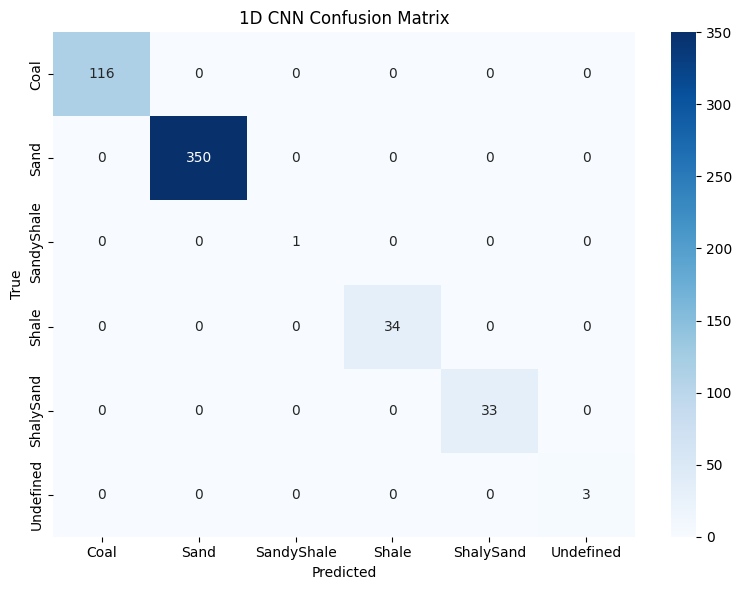

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("1D CNN Confusion Matrix")
plt.tight_layout()
plt.show()
